In [104]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self._prev=set(_children)
        self._backward=lambda:None
        self._op=_op
        self.label=label
        self.grad=0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        
        return out
        
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')
        
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        
        return out
        
    def __neg__(self):
        return self*-1

    def __sub__(self,other):
        return self+(-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self,other):
        return self*other
        
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')
        
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        
        return out

    def backward(self):

        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [189]:
from graphviz import Digraph

def trace(root):
    # 初始化点集合和边集合
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    # 正向图
    dot=Digraph(format='svg',graph_attr={'rankdir':'LR'})

    nodes,edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid,label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad ),shape='record')
        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot
            

In [190]:
# inputs x1 x2
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
# weights w1 w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
# bias of the neuron
b=Value(6.8813735870195432,label='b')
# x1*w1 x2*w2
x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o'

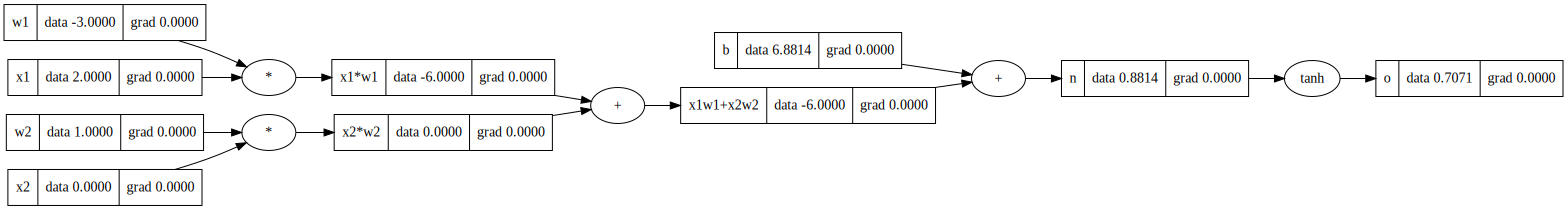

In [192]:
draw_dot(o)

In [201]:
import random
class Neuron:
    # nin : number of input
    def __init__(self,nin):
        # weight
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        # bias
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        act= sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        # activate
        out=act.tanh()
        return out

    def parameters(self):
        return self.w+[self.b]

class Layer:

    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers= [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [202]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.9300267307935153)

In [203]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0]

In [204]:
for k in range(20):
    # 前向传播
    ypred=[n(x) for x in xs]
    loss=sum([(yout-ygt)**2 for ygt,yout in zip(ys ,ypred)])

    # 反向传播
    # 梯度清零
    for p in n.parameters():
        p.grad=0.0
    loss.backward()

    # 更新参数
    for p in n.parameters():
        # 0.15 为学习率
        p.data+= -0.15 *p.grad

    print(k,loss.data)

0 8.92724467996983
1 7.799496100528732
2 7.642723075910126
3 6.942411246559173
4 1.4811646260210833
5 0.4290246797462258
6 0.07591068596329924
7 0.04939302971411735
8 0.03873145781886216
9 0.03239242125806116
10 0.028046586806812566
11 0.024825016426323517
12 0.022314898042755982
13 0.020290307589920665
14 0.01861527009738023
15 0.017202119809246214
16 0.015991310255585117
17 0.014940706878302363
18 0.014019499746954973
19 0.013204544584614803


In [205]:
ypred

[Value(data=0.9670292480497485),
 Value(data=-0.9573199644717987),
 Value(data=-0.9178369909062247),
 Value(data=0.9404590174382597)]